In [1]:
import spacy
import pandas as pd
import requests
from spacy import displacy
 
nlp = spacy.load('en_core_web_sm')
 
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx
 
%matplotlib inline

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML For Good/crisislogger.csv')

In [6]:
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
  
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [14]:
def obtain_relation(sent):
  
   doc = nlp(sent)
  
   matcher = Matcher(nlp.vocab)
  
   pattern = [{'DEP':'ROOT'},
           {'DEP':'prep','OP':"?"},
           {'DEP':'agent','OP':"?"}, 
           {'POS':'ADJ','OP':"?"}]
  
   matcher.add("matching_1", None, pattern)
  
   matcher = matcher(doc)
   h = len(matcher) - 1
  
   span = doc[matcher[h][1]:matcher[h][2]]
  
   return span.text

In [16]:
# Finding the Subject & object
pairs_of_entities = [extract_entities(i) for i in tqdm(data['transcriptions'])]

# Finding the relation between Subject & object
relations = [obtain_relation(j) for j in tqdm(data['transcriptions'])]

100%|██████████| 140/140 [00:06<00:00, 21.89it/s]


In [17]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [62]:
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target", edge_attr=True, create_using=ntx.MultiDiGraph())

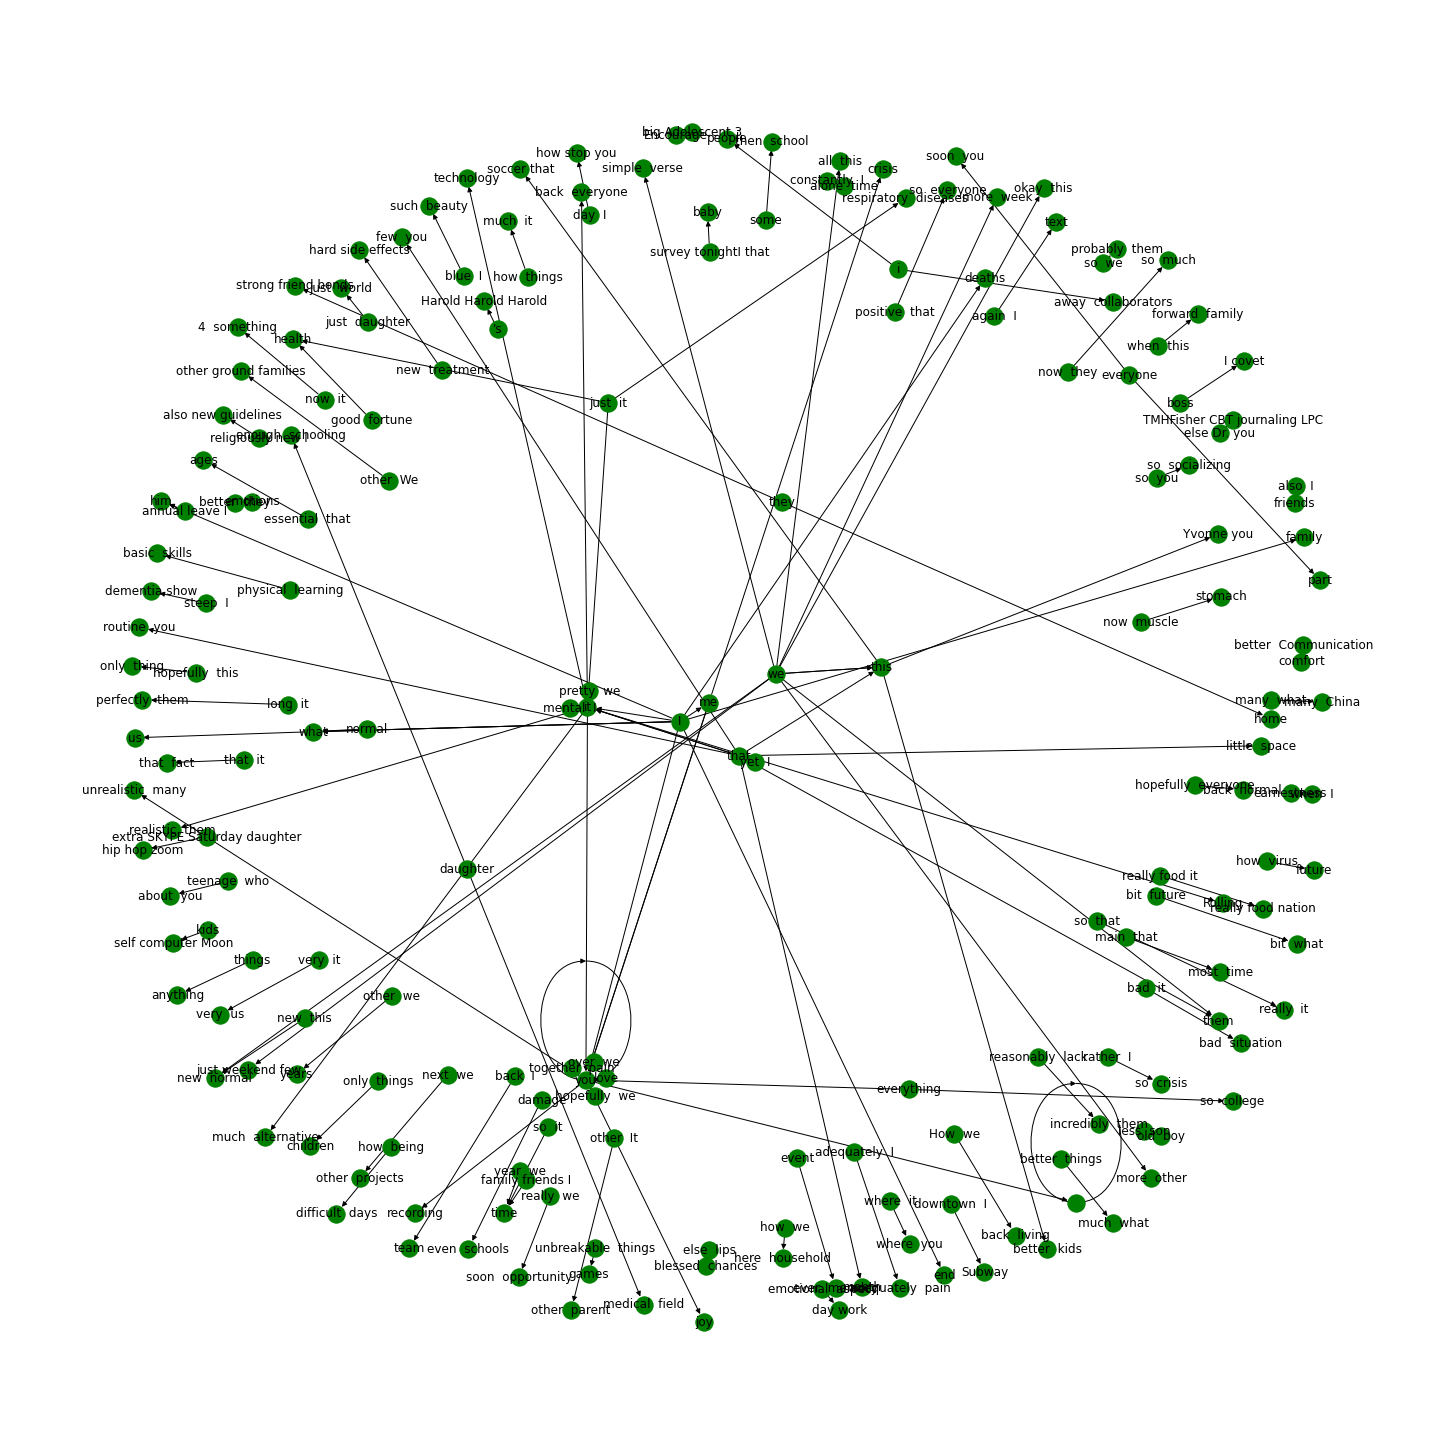

In [63]:
# plotting the network
plot.figure(figsize=(20, 20))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [65]:
# Pre Processing Further
delimiters = ' and ', ' but ', ' yet ', ' because ', '.', '?'
regexPattern = '|'.join(map(re.escape, delimiters))

# Creating new sentences list
sentences_list = []
for sent in data['transcriptions']:
    result = re.split(regexPattern, sent)
    sentences_list.extend(result)

sentences_list = [sent for sent in sentences_list if len(sent) > 2]

In [66]:
# Finding the Subject & object
pairs_of_entitie_2 = [extract_entities(i) for i in tqdm(sentences_list)]

# Finding the relation between Subject & object
relations_2 = [obtain_relation(j) for j in tqdm(sentences_list)]

# subject extraction
source_2 = [j[0] for j in pairs_of_entitie_2]

#object extraction
target_2 = [k[1] for k in pairs_of_entitie_2]

data_kgf_2 = pd.DataFrame({'source':source_2, 'target':target_2, 'edge':relations_2})

100%|██████████| 2254/2254 [00:23<00:00, 95.75it/s]


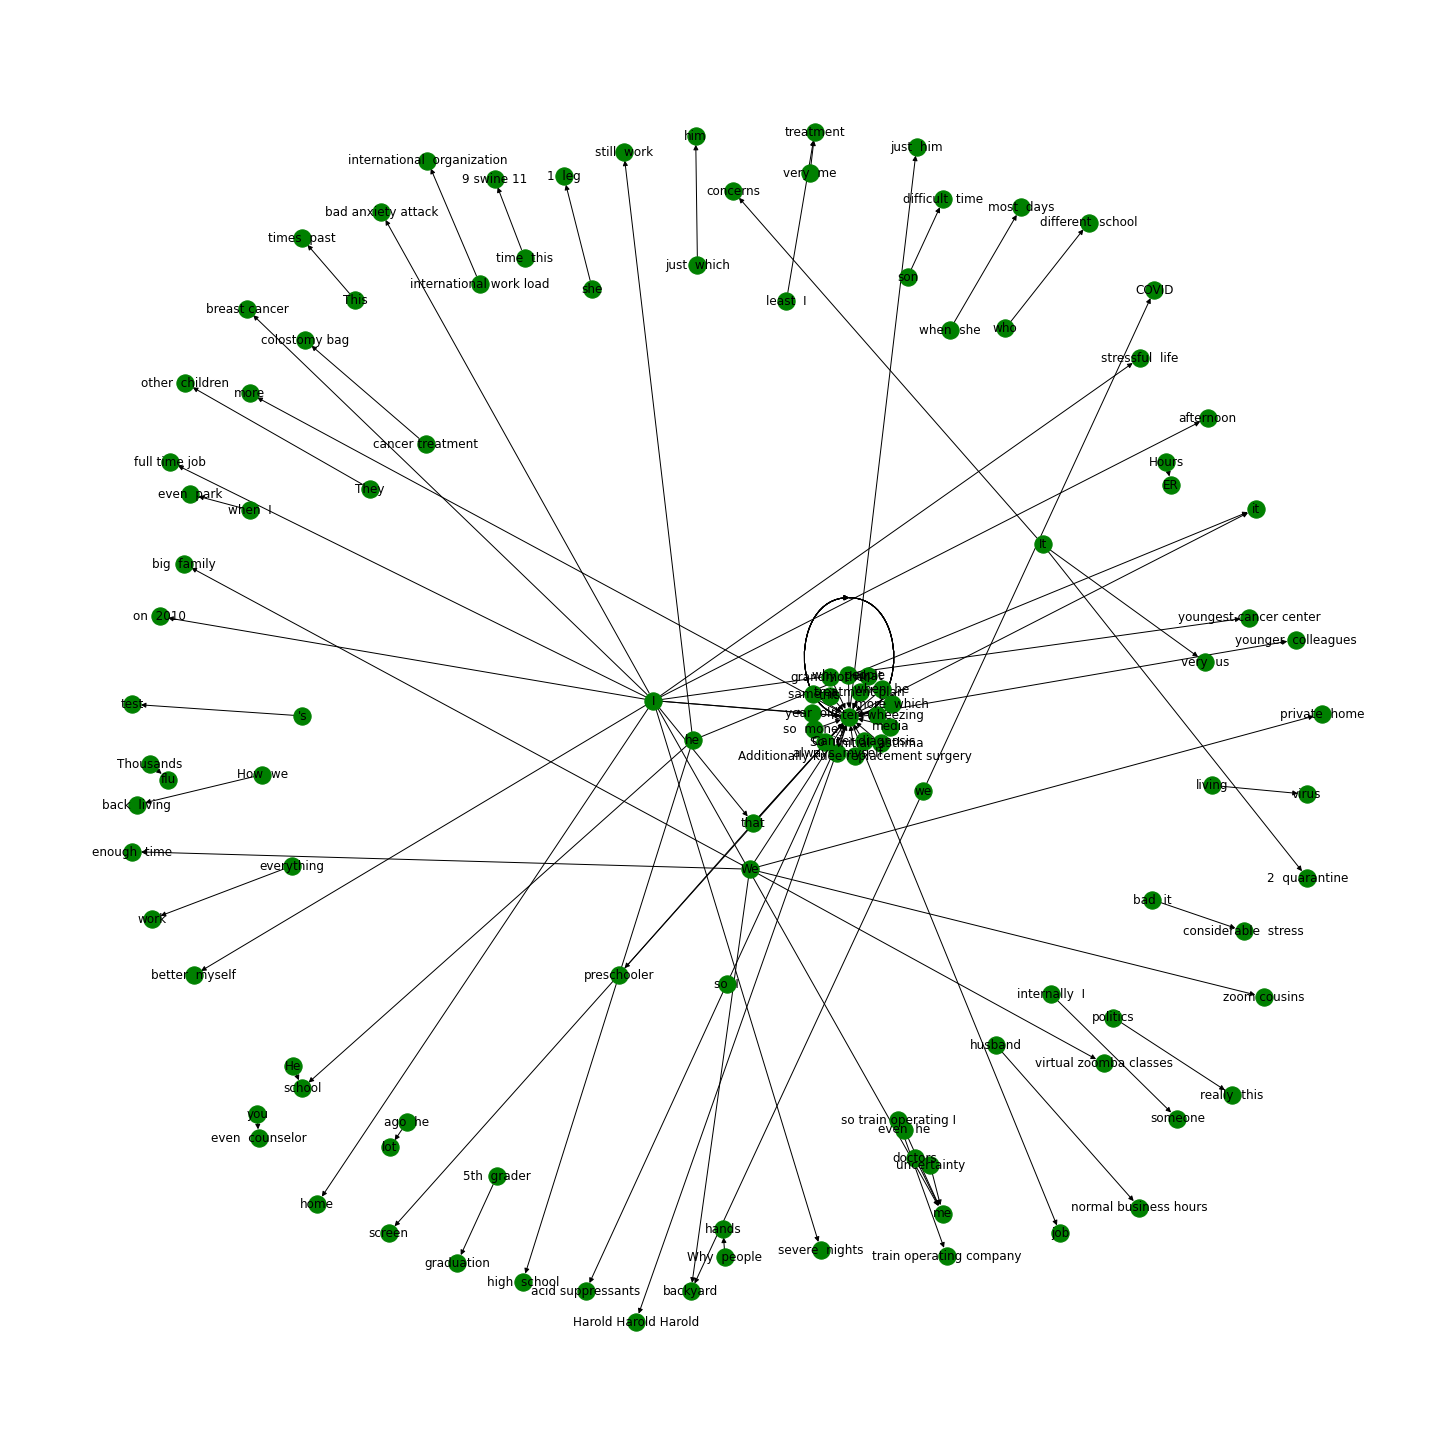

In [68]:
# plotting the network
graph = ntx.from_pandas_edgelist(data_kgf_2[300:400], "source", "target", edge_attr=True, create_using=ntx.MultiDiGraph())
plot.figure(figsize=(20, 20))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

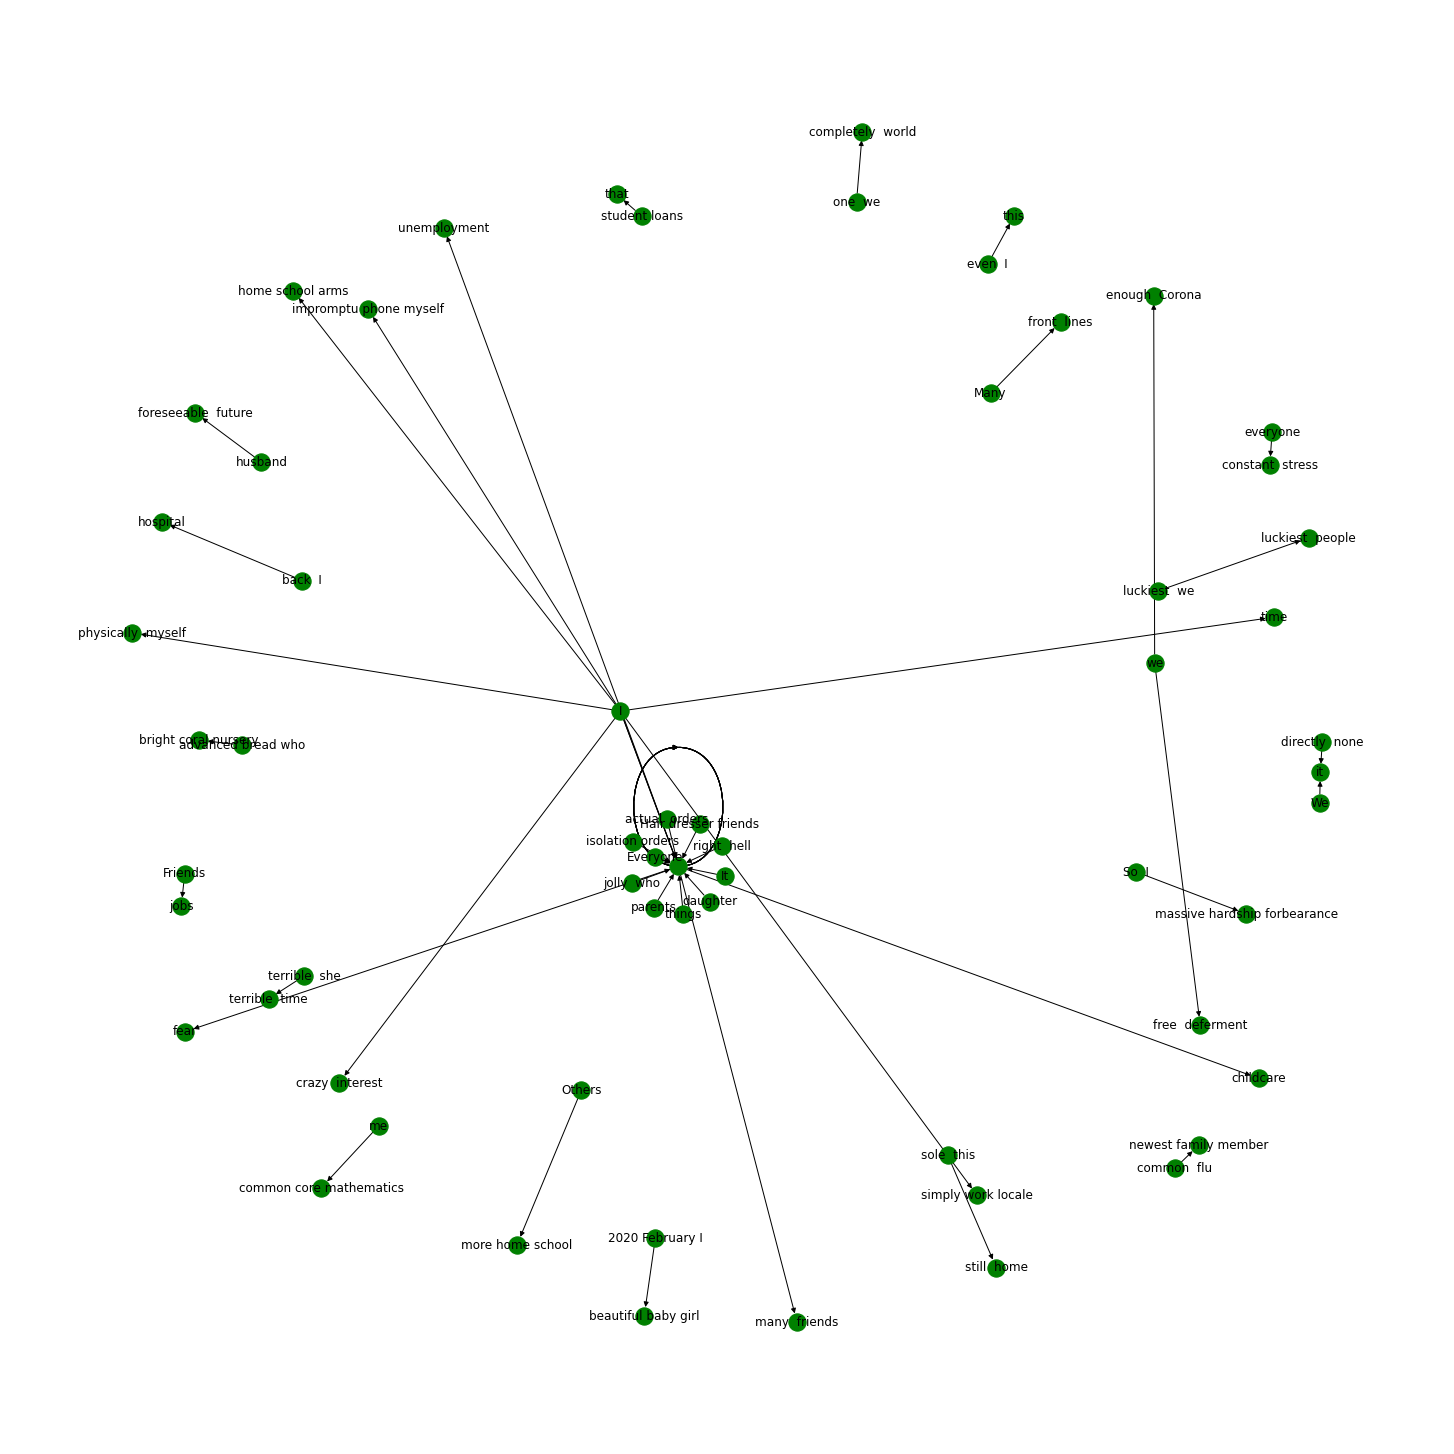

In [72]:
# plotting the network
graph = ntx.from_pandas_edgelist(data_kgf_2[500:550], "source", "target", edge_attr=True, create_using=ntx.MultiDiGraph())
plot.figure(figsize=(20, 20))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

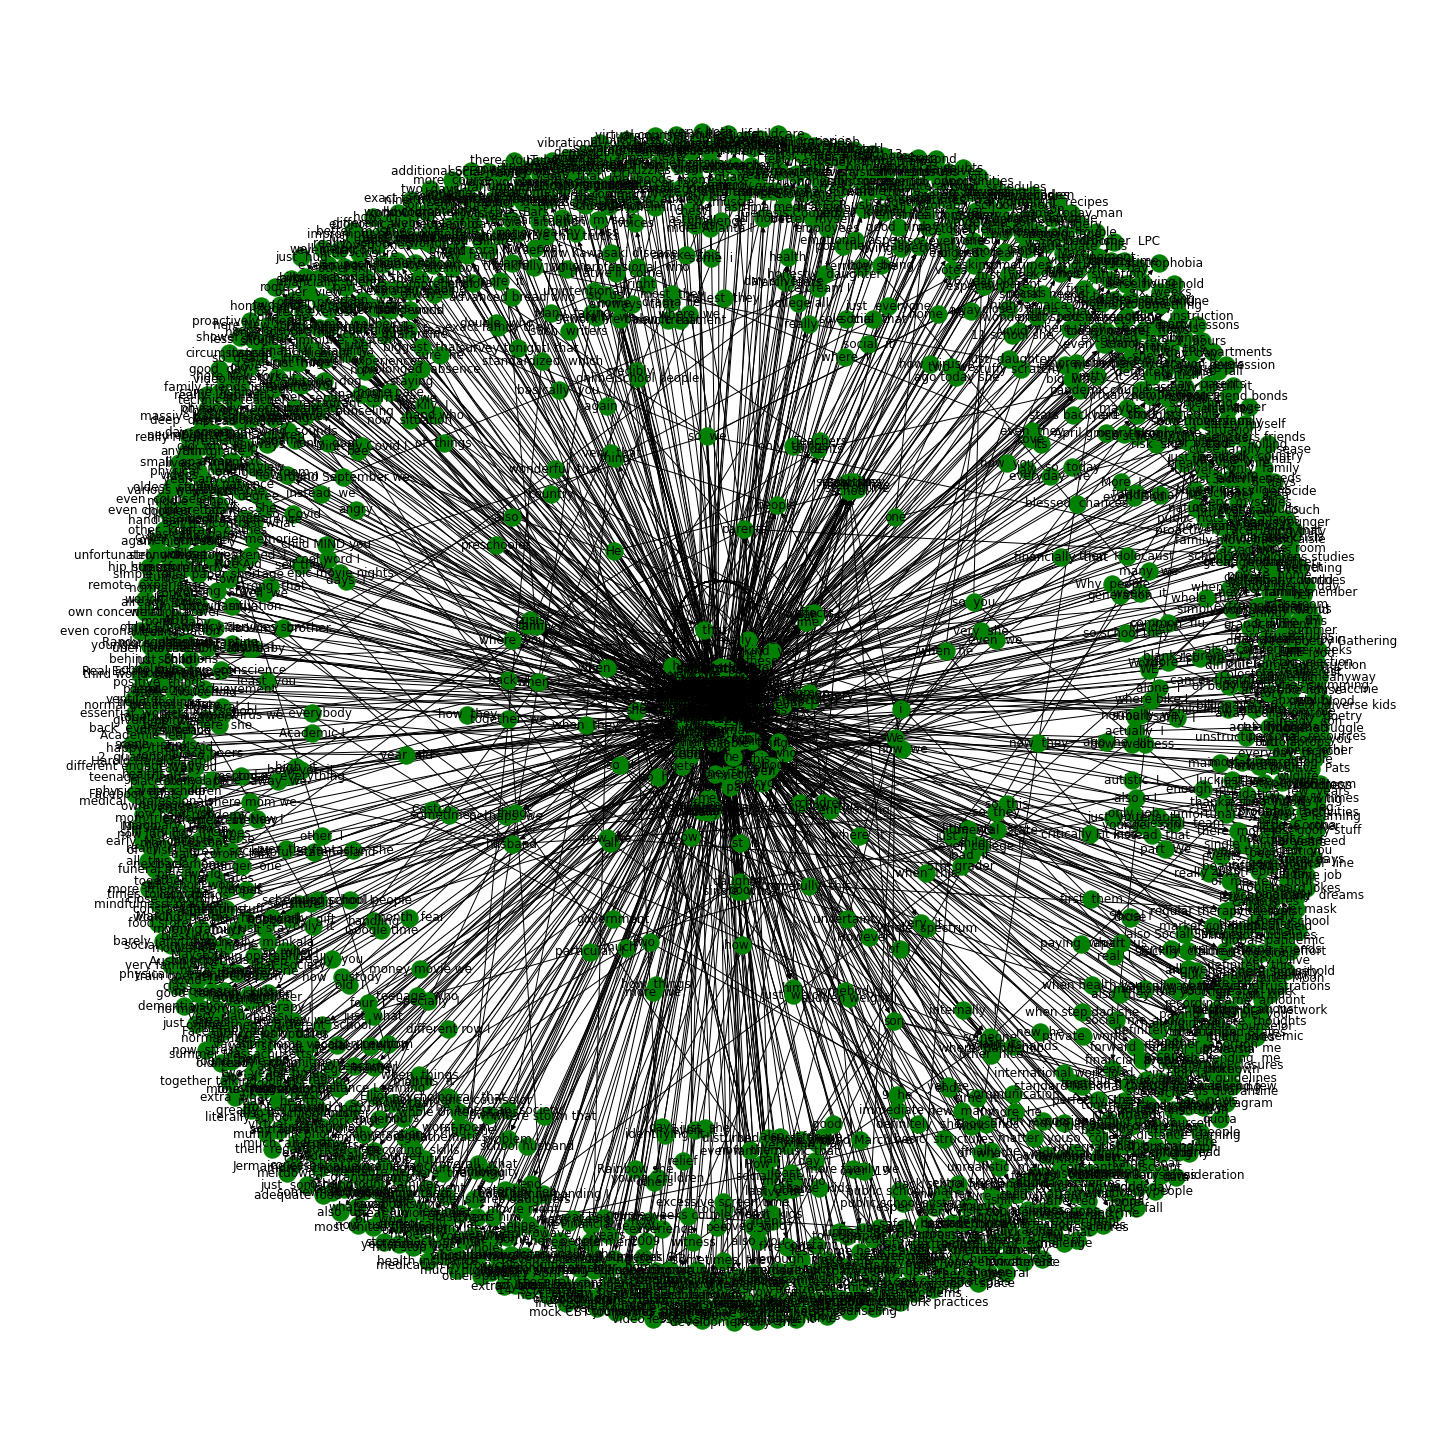

In [73]:
# plotting the network
graph = ntx.from_pandas_edgelist(data_kgf_2, "source", "target", edge_attr=True, create_using=ntx.MultiDiGraph())
plot.figure(figsize=(20, 20))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()